In [22]:
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm

#bins = [i/100 for i in range(30,101, 5)]
f_bert= "/data/tfink/kodicare/trec-2019-dl/doc_ret/triplets_bert.train.id"
f_tfidf= "/data/tfink/kodicare/trec-2019-dl/doc_ret/triplets_tfidf.train.id"

def get_x_score(f):
    x_score = []
    with open(f, "r") as fp:
        for line in tqdm(fp):
            q_id, positive, negative, score = line.split()
            score = float(score)
            x_score.append(score)
    return x_score

x_bert = get_x_score(f_bert)
x_tfidf = get_x_score(f_tfidf)


36222621it [00:25, 1419625.06it/s]
20396848it [00:14, 1364183.02it/s]


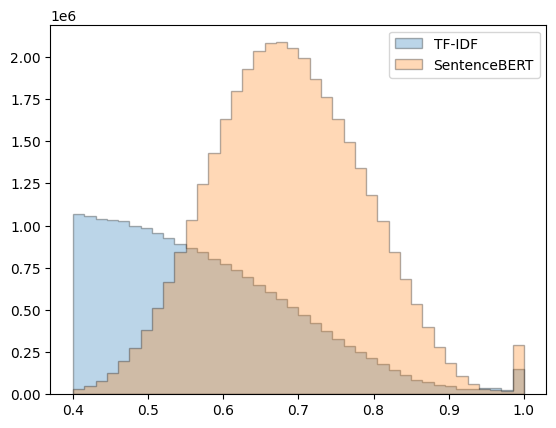

In [23]:
kwargs = dict(histtype='stepfilled', alpha=0.3, ec='k', range=(0.4,1.0))

#pyplot.hist(x_tfidf, bins, label='TF-IDF', **kwargs)
#pyplot.hist(x_bert, bins, label='SentenceBERT', **kwargs)
pyplot.hist(x_tfidf, bins=40, label='TF-IDF', **kwargs)
pyplot.hist(x_bert, bins=40, label='SentenceBERT', **kwargs)
pyplot.legend(loc='upper right')
pyplot.show()

In [55]:
from decimal import Decimal, getcontext
getcontext().prec = 2

def count_values_in_buckets(value_list):
    # buckets are from 0 to 2 because of float errors
    # --> adjust labels when printed
    # Initialize buckets
    buckets = {i / 10: [] for i in range(21)}  # 21 buckets from -1.0 to 1.0

    # Assign values to buckets
    for value in value_list:
        bucket_key = int((value + 1) * 10) / 10  # Adjusting for the range
        buckets[bucket_key].append(value)

    # Count values in each bucket
    bucket_counts = {key: len(values) for key, values in buckets.items()}
    
    return bucket_counts


def get_aggregated_bucket_count_list(bucket_counts_list):
    aggregated_bucket_count_list = {}

    # Iterate over each bucket counts
    for bucket_counts in bucket_counts_list:
        for bucket, count in bucket_counts.items():
            if bucket not in aggregated_bucket_count_list:
                aggregated_bucket_count_list[bucket] = []
            aggregated_bucket_count_list[bucket].append(count)

    return aggregated_bucket_count_list


def print_stats_table(stats):
    # Print table header
    print("-" * 60)
    print("Bucket\t\tMedian\t\tMean\t\tStandard Deviation")
    print("-" * 60)
    
    # Print stats for each bucket
    for bucket, stat in stats.items():
        print(f"{Decimal(bucket)-Decimal(1)}\t\t{stat['median']:.2f}\t\t{stat['mean']:.2f}\t\t{stat['std_dev']:.2f}")
    print()


def print_simple_stats(stats, header):
    # Print table header
    print(header)
    print("-" * 80)
    print("Q1\t\tMedian\t\tQ3\t\tMean\t\tStandard Deviation")
    print("-" * 80)
    
    print(f"{stats['first_quartile']-1:.2f}\t\t{stats['median']-1:.2f}\t\t{stats['third_quartile']-1:.2f}\t\t{stats['mean']-1:.2f}\t\t{stats['std_dev']:.2f}")
    print()


def get_stats(f):
    x_scores = {}
    bucket_counts_dict = {}
    aggregated_bucket_count_list = {}
    stats = {}
    returned_per_positive = []
    with open(f, "r") as fp:
        for line in tqdm(fp):
            q_id, positive, negative, score = line.split()
            score = float(score)
            if (q_id, positive) not in x_scores:
                x_scores[(q_id, positive)] = []
            x_scores[(q_id, positive)].append(score)
    for (q_id, positive), scores in x_scores.items():
        returned_per_positive.append(len(scores))
        bucket_counts_dict[(q_id, positive)] = count_values_in_buckets(scores)

    # Iterate over each bucket counts
    lowest_buckets = []
    for (q_id, positive), bucket_counts in bucket_counts_dict.items():
        lowest_bucket = 2
        for bucket, count in bucket_counts.items():
            if bucket not in aggregated_bucket_count_list:
                aggregated_bucket_count_list[bucket] = []
            aggregated_bucket_count_list[bucket].append(count)
            if count > 0 and bucket < lowest_bucket:
                lowest_bucket = bucket
        lowest_buckets.append(lowest_bucket)

    
    for bucket, counts in aggregated_bucket_count_list.items():
        median = np.median(counts)
        mean = np.mean(counts)
        std_dev = np.std(counts)
        stats[bucket] = {'median': median, 'mean': mean, 'std_dev': std_dev}
    
    # distribution of the lowest buckets
    median = np.median(lowest_buckets)
    mean = np.mean(lowest_buckets)
    std_dev = np.std(lowest_buckets)
    first_quartile = np.quantile(lowest_buckets, 0.25)
    third_quartile = np.quantile(lowest_buckets, 0.75)
    lowest_bucket_stats = {'first_quartile': first_quartile, 'median': median, 'third_quartile': third_quartile, 'mean': mean, 'std_dev': std_dev}

    # general number of returned documents
    median = np.median(returned_per_positive)
    mean = np.mean(returned_per_positive)
    std_dev = np.std(returned_per_positive)
    first_quartile = np.quantile(returned_per_positive, 0.25)
    third_quartile = np.quantile(returned_per_positive, 0.75)
    returned_per_positive_stats = {'first_quartile': first_quartile, 'median': median, 'third_quartile': third_quartile, 'mean': mean, 'std_dev': std_dev}

    return stats, lowest_bucket_stats, returned_per_positive_stats

stats, lowest_bucket_stats, returned_per_positive_stats = get_stats(f_bert)

# Print stats
print("SentenceBERT")
print_stats_table(stats)
print_simple_stats(lowest_bucket_stats, "Lowest Bucket Stats")
print_simple_stats(returned_per_positive_stats, "Returned Positives")

stats, lowest_bucket_stats, returned_per_positive_stats = get_stats(f_tfidf)


# Print stats
print("TF-IDF")
print_stats_table(stats)
print_simple_stats(lowest_bucket_stats, "Lowest Bucket Stats")
print_simple_stats(returned_per_positive_stats, "Returned Positives")

0it [00:00, ?it/s]

36222621it [00:35, 1020757.69it/s]


SentenceBERT
------------------------------------------------------------
Bucket		Median		Mean		Standard Deviation
------------------------------------------------------------
-1		0.00		0.00		0.00
-0.90		0.00		0.00		0.00
-0.80		0.00		0.00		0.00
-0.70		0.00		0.00		0.00
-0.60		0.00		0.00		0.00
-0.5		0.00		0.00		0.00
-0.40		0.00		0.00		0.00
-0.30		0.00		0.00		0.00
-0.20		0.00		0.00		0.00
-0.10		0.00		0.00		0.00
0		0.00		0.00		0.00
0.10		0.00		0.00		0.00
0.20		0.00		0.00		0.00
0.30		0.00		0.00		0.00
0.40		0.00		2.72		12.63
0.5		0.00		17.44		28.34
0.60		33.00		35.74		30.69
0.70		20.00		29.74		27.85
0.80		4.00		11.51		18.44
0.90		0.00		1.11		4.81
1		0.00		0.67		6.81

Lowest Bucket Stats
--------------------------------------------------------------------------------
Q1		Median		Q3		Mean		Standard Deviation
--------------------------------------------------------------------------------
0.50		0.60		0.60		0.58		0.09

Returned Positives
----------------------------------------------------------

20396848it [00:20, 977914.98it/s] 


TF-IDF
------------------------------------------------------------
Bucket		Median		Mean		Standard Deviation
------------------------------------------------------------
-1		0.00		0.00		0.00
-0.90		0.00		0.00		0.00
-0.80		0.00		0.00		0.00
-0.70		0.00		0.00		0.00
-0.60		0.00		0.00		0.00
-0.5		0.00		0.00		0.00
-0.40		0.00		0.00		0.00
-0.30		0.00		0.00		0.00
-0.20		0.00		0.00		0.00
-0.10		0.00		0.00		0.00
0		0.00		0.00		0.00
0.10		0.00		0.00		0.00
0.20		0.00		0.00		0.00
0.30		0.00		0.00		0.00
0.40		8.00		20.03		25.44
0.5		6.00		17.08		23.18
0.60		3.00		12.45		20.67
0.70		0.00		6.64		15.69
0.80		0.00		2.15		9.22
0.90		0.00		0.62		6.19
1		0.00		0.37		5.58

Lowest Bucket Stats
--------------------------------------------------------------------------------
Q1		Median		Q3		Mean		Standard Deviation
--------------------------------------------------------------------------------
0.40		0.40		0.50		0.45		0.09

Returned Positives
--------------------------------------------------------------------

In [40]:
x_scores = {}
bucket_counts_dict = {}
aggregated_bucket_count_list = {}
stats = {}
returned_per_positive = []
with open(f_tfidf, "r") as fp:
    for line in tqdm(fp):
        q_id, positive, negative, score = line.split()
        score = float(score)
        if (q_id, positive) not in x_scores:
            x_scores[(q_id, positive)] = []
        x_scores[(q_id, positive)].append(score)
for (q_id, positive), scores in x_scores.items():
    returned_per_positive.append(len(scores))
    bucket_counts_dict[(q_id, positive)] = count_values_in_buckets(scores)

# Iterate over each bucket counts
lowest_buckets = []
for (q_id, positive), bucket_counts in bucket_counts_dict.items():
    lowest_bucket = 2
    for bucket, count in bucket_counts.items():
        if bucket not in aggregated_bucket_count_list:
            aggregated_bucket_count_list[bucket] = []
        aggregated_bucket_count_list[bucket].append(count)
        if count > 0 and bucket < lowest_bucket:
            lowest_bucket = bucket
    lowest_buckets.append(lowest_bucket)


for bucket, counts in aggregated_bucket_count_list.items():
    median = np.median(counts)
    mean = np.mean(counts)
    std_dev = np.std(counts)
    stats[bucket] = {'median': median, 'mean': mean, 'std_dev': std_dev}

median = np.median(lowest_buckets)
mean = np.mean(lowest_buckets)
std_dev = np.std(lowest_buckets)
first_quartile = np.quantile(lowest_buckets, 0.25)
third_quartile = np.quantile(lowest_buckets, 0.75)
lowest_bucket_stats = {'first_quartile': first_quartile, 'median': median, 'third_quartile': third_quartile, 'mean': mean, 'std_dev': std_dev}

20396848it [00:24, 827567.94it/s]


In [53]:
print(stats[1.4])
bucket_counts_dict

{'median': 8.0, 'mean': 20.027187844612623, 'std_dev': 25.44179250624823}


{('3', 'D312959'): {0.0: 0,
  0.1: 0,
  0.2: 0,
  0.3: 0,
  0.4: 0,
  0.5: 0,
  0.6: 0,
  0.7: 0,
  0.8: 0,
  0.9: 0,
  1.0: 0,
  1.1: 0,
  1.2: 0,
  1.3: 0,
  1.4: 44,
  1.5: 18,
  1.6: 2,
  1.7: 2,
  1.8: 0,
  1.9: 2,
  2.0: 0},
 ('5', 'D140227'): {0.0: 0,
  0.1: 0,
  0.2: 0,
  0.3: 0,
  0.4: 0,
  0.5: 0,
  0.6: 0,
  0.7: 0,
  0.8: 0,
  0.9: 0,
  1.0: 0,
  1.1: 0,
  1.2: 0,
  1.3: 0,
  1.4: 8,
  1.5: 7,
  1.6: 13,
  1.7: 18,
  1.8: 0,
  1.9: 0,
  2.0: 0},
 ('12', 'D213890'): {0.0: 0,
  0.1: 0,
  0.2: 0,
  0.3: 0,
  0.4: 0,
  0.5: 0,
  0.6: 0,
  0.7: 0,
  0.8: 0,
  0.9: 0,
  1.0: 0,
  1.1: 0,
  1.2: 0,
  1.3: 0,
  1.4: 2,
  1.5: 5,
  1.6: 4,
  1.7: 13,
  1.8: 14,
  1.9: 0,
  2.0: 0},
 ('15', 'D1033338'): {0.0: 0,
  0.1: 0,
  0.2: 0,
  0.3: 0,
  0.4: 0,
  0.5: 0,
  0.6: 0,
  0.7: 0,
  0.8: 0,
  0.9: 0,
  1.0: 0,
  1.1: 0,
  1.2: 0,
  1.3: 0,
  1.4: 8,
  1.5: 2,
  1.6: 4,
  1.7: 0,
  1.8: 0,
  1.9: 0,
  2.0: 0},
 ('16', 'D508131'): {0.0: 0,
  0.1: 0,
  0.2: 0,
  0.3: 0,
  0.4: 0,
  0.5:

In [56]:
def count_values_in_buckets(value_list):
    # buckets are from 0 to 2 because of float errors
    # --> adjust labels when printed
    # Initialize buckets
    buckets = {i / 10: [] for i in range(21)}  # 21 buckets from -1.0 to 1.0

    # Assign values to buckets
    for value in value_list:
        bucket_key = int((value + 1) * 10) / 10  # Adjusting for the range
        buckets[bucket_key].append(value)

    # Count values in each bucket
    bucket_counts = {key: len(values) for key, values in buckets.items()}
    
    return bucket_counts

# Example list of values
values = [1.0, 0.4, -0.8, 0.45, -0.05, -1.0]

# Count values in buckets
bucket_counts = count_values_in_buckets(values)

# Print bucket counts
for bucket, count in bucket_counts.items():
    print(f"{bucket-1:.1f} bucket: {bucket_counts[bucket]} -> size {count}")


KeyError: -3.4028234663852886e+38

In [25]:
def aggregate_bucket_counts(bucket_counts_list):
    aggregated_bucket_count_list = {}

    # Iterate over each bucket counts
    for bucket_counts in bucket_counts_list:
        for bucket, count in bucket_counts.items():
            if bucket not in aggregated_bucket_count_list:
                aggregated_bucket_count_list[bucket] = []
            aggregated_bucket_count_list[bucket].append(count)

    return aggregated_bucket_count_list

# Example list of bucket counts
bucket_counts1 = {0.0: 2, 0.1: 0, 0.2: 0, 0.3: 0, 0.4: 2, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 1, 0.9: 0, 1.0: 2}
bucket_counts2 = {0.0: 1, 0.1: 0, 0.2: 0, 0.3: 0, 0.4: 1, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 1, 0.9: 0, 1.0: 1}
bucket_counts3 = {0.0: 0, 0.1: 0, 0.2: 0, 0.3: 0, 0.4: 1, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 2, 0.9: 0, 1.0: 1}

# List of bucket counts
bucket_counts_list = [bucket_counts1, bucket_counts2, bucket_counts3]

# Aggregate bucket counts
aggregated_bucket_count_list = aggregate_bucket_counts(bucket_counts_list)

# Print aggregated bucket counts
for bucket, counts in aggregated_bucket_count_list.items():
    print(f"{bucket} bucket: {counts}")


0.0 bucket: [2, 1, 0]
0.1 bucket: [0, 0, 0]
0.2 bucket: [0, 0, 0]
0.3 bucket: [0, 0, 0]
0.4 bucket: [2, 1, 1]
0.5 bucket: [0, 0, 0]
0.6 bucket: [0, 0, 0]
0.7 bucket: [0, 0, 0]
0.8 bucket: [1, 1, 2]
0.9 bucket: [0, 0, 0]
1.0 bucket: [2, 1, 1]


In [26]:
import numpy as np

def aggregate_bucket_counts(bucket_count_lists):
    aggregated_bucket_count_list = {}
    
    for bucket_counts in bucket_count_lists:
        for bucket, count in bucket_counts.items():
            if bucket not in aggregated_bucket_count_list:
                aggregated_bucket_count_list[bucket] = []
            aggregated_bucket_count_list[bucket].append(count)
    
    return aggregated_bucket_count_list

def calculate_stats(aggregated_bucket_count_list):
    stats = {}
    
    for bucket, counts in aggregated_bucket_count_list.items():
        median = np.median(counts)
        mean = np.mean(counts)
        std_dev = np.std(counts)
        stats[bucket] = {'median': median, 'mean': mean, 'std_dev': std_dev}
    
    return stats

# Example bucket count lists
bucket_counts1 = {0.1: 2, 0.2: 3, 0.3: 1}
bucket_counts2 = {0.1: 1, 0.2: 4, 0.3: 2}
bucket_counts3 = {0.1: 3, 0.2: 2, 0.3: 5}

bucket_count_lists = [bucket_counts1, bucket_counts2, bucket_counts3]

# Aggregate bucket counts
aggregated_bucket_count_list = aggregate_bucket_counts(bucket_count_lists)

# Calculate stats for aggregated bucket counts
stats = calculate_stats(aggregated_bucket_count_list)

# Print stats
for bucket, stat in stats.items():
    print(f"Bucket: {bucket}")
    print(f"  Median: {stat['median']}")
    print(f"  Mean: {stat['mean']}")
    print(f"  Standard Deviation: {stat['std_dev']}")


Bucket: 0.1
  Median: 2.0
  Mean: 2.0
  Standard Deviation: 0.816496580927726
Bucket: 0.2
  Median: 3.0
  Mean: 3.0
  Standard Deviation: 0.816496580927726
Bucket: 0.3
  Median: 2.0
  Mean: 2.6666666666666665
  Standard Deviation: 1.699673171197595


In [35]:
def print_stats_table(stats):
    # Print table header
    print("Bucket\t\tMedian\t\tMean\t\tStandard Deviation")
    print("-" * 60)
    
    # Print stats for each bucket
    for bucket, stat in stats.items():
        print(f"{bucket}\t\t{stat['median']:.2f}\t\t{stat['mean']:.2f}\t\t{stat['std_dev']:.2f}")
    
# Example bucket count lists
bucket_counts1 = {0.1: [2, 1, 3], 0.2: [3, 4, 2], 0.3: [1, 2, 5]}
bucket_counts2 = {0.1: [1, 2, 3], 0.2: [4, 3, 2], 0.3: [2, 1, 4]}
bucket_counts3 = {0.1: [3, 3, 3], 0.2: [2, 4, 3], 0.3: [5, 2, 3]}

bucket_count_lists = [bucket_counts1, bucket_counts2, bucket_counts3]

# Aggregate bucket counts
aggregated_bucket_count_list = aggregate_bucket_counts(bucket_count_lists)

# Calculate stats for aggregated bucket counts
stats = calculate_stats(aggregated_bucket_count_list)

# Print stats as a table
print_stats_table(stats)


Bucket		Median		Mean		Standard Deviation
------------------------------------------------------------
0.1		3.00		2.33		0.82
0.2		3.00		3.00		0.82
0.3		2.00		2.78		1.47
